Load dependencies

In [ ]:
using Revise # drop later
using StableDQMC
using BenchmarkTools
using LinearAlgebra
using Statistics
using Test
using GenericSVD
using JacobiSVD
using Plots
using StatsPlots
using LaTeXStrings
using DataStructures
using DataFrames
using DoubleFloats
using BSON: @save, @load

Configure plotting defaults

In [ ]:
pyplot();
PyPlot.plt.style.use(joinpath(pwd(),"publication_tex.mplstyle"))
default(
    framestyle = :grid,
    grid = true,
    guidefont=font(15),
#     framestyle = :box,
#     grid = false,
#     guidefont=font(18),
    legend = true,
    size = (1.6*360, 360),
    xtickfont=font(13), 
    ytickfont=font(13), 
    legendfont=font(12),
    linewidth = 1.5
);

Basic tests

In [ ]:
@testset "Basic tests" begin
    B = rand(5,5) # regular matrix
    N = 10
    @test isapprox(calc_Bchain(B, N)[1], B^N)
    @test isapprox(Matrix(calc_Bchain_svd(B, N; svdalg = gesdd)[1]), B^N)
    @test isapprox(Matrix(calc_Bchain_svd(B, N; svdalg =  gesvd)[1]), B^N)
    @test isapprox(Matrix(calc_Bchain_svd(B, N; svdalg =  genericsvd)[1]), B^N)
    @test isapprox(Matrix(calc_Bchain_qr(B, N)[1]), B^N)
end;

# Hubbard model

In [ ]:
# Parameters
nsites = 4
n = nsites * 2 # spin
t = 1
μ = 0
Δτ = 0.1

# Kinetic part (PBC)
T = diagm(-1 => fill(-t, n-1), 1 => fill(-t, n-1), 0 => fill(μ, n))
T[1,end] = -t; T[end,1] = -t;

# On-site interaction
function eU(U)
    λ = acosh(exp(0.5*U*Δτ))
    Diagonal(vcat(fill(exp(λ), nsites), fill(exp(-λ), nsites)))
end

B0 = exp(-Δτ .* T)            # non-interacting
B1 = exp(-Δτ .* T) * eU(1);   # U = 1
B4 = exp(-Δτ .* T) * eU(4);   # U = 4

## Non-interacting

Compare to exact discretized energies

In [ ]:
ks = LinRange(-pi, pi, n+1)[1:end-1]
ϵ(k) = -2*t*cos(k) + μ
sort(ϵ.(ks))

plot(ks, sort(ϵ.(ks)), marker=true, label="exact")
plot!(ks, eigvals(T), marker=true, label="eigenvalues")

Condition number and breakdown estimation

In [ ]:
kappa(N) = exp(4abs(t)*N*Δτ)

In [ ]:
cond(B0) # from LinearAlgebra

In [ ]:
@test kappa(1) ≈ cond(B0)

In [ ]:
estimate_breakdown(sigdigits) = sigdigits * log(10) / (4 * abs(t) * Δτ)

In [ ]:
estimate_breakdown(17)

# Slice matrix product chain

## Instabilities

In [ ]:
N = 500
betas = range(1, N * 0.1, length=N)
svs_naive = calc_Bchain(B0, N)[2];

Compute with "arbitrary" floating point precision for comparison

In [ ]:
Bbig = BigFloat.(B0)
setprecision(1000) do
    global svs_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[2];
end;

In [ ]:
plot(betas, svs_genericsvd, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-17, 40), color=:darkgray, linestyle=:dash, label = "Float64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("../paper/figures/naive_vs_stable.pdf")

In [ ]:
Bdb64 = Double64.(B0)
svs_naive = calc_Bchain(Bdb64, N)[2];

In [ ]:
plot(betas, svs_genericsvd, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-34, 40), color=:darkgray, linestyle=:dash, label = "Double64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("../paper/figures/naive_vs_stable_db64.pdf")

## Compute slice matrix product chain using different stabilizations

In [ ]:
svs_qr_udt = calc_Bchain_qr(B0, N)[2];
svs_gesvd  = calc_Bchain_svd(B0, N; svdalg = gesvd)[2];
svs_gesdd  = calc_Bchain_svd(B0, N; svdalg = gesdd)[2];
svs_gesvj  = calc_Bchain_svd(B0, N; svdalg = gesvj)[2];

In [ ]:
betas = range(1, N * 0.1, length=N)
plot(betas, svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-160, 100)
xlims!(0., 50.)
savefig("../paper/figures/decomp_comparison_simple.pdf")

Condition number (UDT/QR) at large $\beta$

In [ ]:
cond(exp.(svs_qr_udt[end,:]))

In [ ]:
kappa(N)

# Accuracy: Equal-times Green's function

In [ ]:
function accuracy_greens(B; svdinversion = inv_one_plus)
    Bbig = BigFloat.(B)
    
    Δs_qr    = SortedDict{Int, Float64}()
    Δs_gesvd = SortedDict{Int, Float64}()
    Δs_gesdd = SortedDict{Int, Float64}()
    Δs_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local G_genericsvd
        setprecision(1000) do
            F_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[1];
            G_genericsvd = inv(I + Matrix(F_genericsvd))
        end
        
        # Bchain
        F_qr_udt = calc_Bchain_qr(B, N)[1];
        F_gesvd  = calc_Bchain_svd(B, N; svdalg = gesvd)[1];
        F_gesdd  = calc_Bchain_svd(B, N; svdalg = gesdd)[1];
        F_gesvj  = calc_Bchain_svd(B, N; svdalg = StableDQMC.gesvj)[1];
        
        # inversion
        G_qr_udt = inv_one_plus(F_qr_udt)
        G_gesvd  = svdinversion(F_gesvd; svdalg = gesvd!)
        G_gesdd  = svdinversion(F_gesdd; svdalg = gesdd!)
        G_gesvj  = svdinversion(F_gesvj; svdalg = StableDQMC.gesvj!)
        
        Δs_qr[beta]    = maximum(abs.(G_qr_udt - G_genericsvd))
        Δs_gesvd[beta] = maximum(abs.(G_gesvd - G_genericsvd))
        Δs_gesdd[beta] = maximum(abs.(G_gesdd - G_genericsvd))
        Δs_gesvj[beta] = maximum(abs.(G_gesvj - G_genericsvd))
    end
    

    return Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj
end

## Regular inversion

In [ ]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B0);
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B1);
plot!(betas, log.(10, values(Δs_qr)), color="#E66101", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", alpha=.3, msc="#666666", marker=true, label="")


xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
# ylims!(0., 1e-3)
savefig("../paper/figures/accuracy_greens_svd_regularinv.pdf")

## Loh et al inversion

In [ ]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B0, svdinversion = inv_one_plus_loh);
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B1, svdinversion = inv_one_plus_loh);
plot!(betas, log.(10, values(Δs_qr)), color="#E66101", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", alpha=.3, msc="#666666", marker=true, label="")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", alpha=.3, msc="#666666", marker=true, label="")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
savefig("../paper/figures/accuracy_greens_svd_loh.pdf")

# Accuracy: Determinant

In [ ]:
absdiff(x,y) = abs(x-y)
reldiff(x, y) = abs((x - y) / (x + y))

function accuracy_determinant(B; svdinversion = svd_inv_one_plus)
    Bbig = BigFloat.(B)
    
    Δs_abs_qr    = SortedDict{Int, Float64}()
    Δs_abs_gesvd = SortedDict{Int, Float64}()
    Δs_abs_gesdd = SortedDict{Int, Float64}()
    Δs_abs_gesvj = SortedDict{Int, Float64}()
    
    Δs_rel_qr    = SortedDict{Int, Float64}()
    Δs_rel_gesvd = SortedDict{Int, Float64}()
    Δs_rel_gesdd = SortedDict{Int, Float64}()
    Δs_rel_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local det_genericsvd
        setprecision(1000) do
            F_genericsvd = calc_Bchain_svd(Bbig, N; svdalg = genericsvd)[1];
            det_genericsvd = prod(svd_inv_one_plus(F_genericsvd).S)
        end
        
        # Bchain
        F_qr_udt   = calc_Bchain_qr(B, N)[1];
        F_gesvd    = calc_Bchain_svd(B, N; svdalg = gesvd)[1];
        F_gesdd    = calc_Bchain_svd(B, N; svdalg = gesdd)[1];
        F_gesvj    = calc_Bchain_svd(B, N; svdalg = gesvj)[1];
        
        # inversion + det extraction
        det_qr_udt = prod(udt_inv_one_plus(F_qr_udt).D)
        det_gesvd  = prod(svdinversion(F_gesvd; svdalg = gesvd!).S)
        det_gesdd  = prod(svdinversion(F_gesdd; svdalg = gesdd!).S)
        det_gesvj  = prod(svdinversion(F_gesvj; svdalg = StableDQMC.gesvj!).S)
        
        Δs_abs_qr[beta]    = absdiff(det_qr_udt, det_genericsvd)
        Δs_abs_gesvd[beta] = absdiff(det_gesvd, det_genericsvd)
        Δs_abs_gesdd[beta] = absdiff(det_gesdd, det_genericsvd)
        Δs_abs_gesvj[beta] = absdiff(det_gesvj, det_genericsvd)
        
        Δs_rel_qr[beta]    = reldiff(det_qr_udt, det_genericsvd)
        Δs_rel_gesvd[beta] = reldiff(det_gesvd, det_genericsvd)
        Δs_rel_gesdd[beta] = reldiff(det_gesdd, det_genericsvd)
        Δs_rel_gesvj[beta] = reldiff(det_gesvj, det_genericsvd)
    end
    

    return Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
            Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj
end

## Regular inversion

In [ ]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B0, svdinversion = svd_inv_one_plus)
betas = collect(keys(Δs_rel_qr))

p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B1, svdinversion = svd_inv_one_plus)
plot!(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, msc="#666666", alpha=.3, label="")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G, \textrm{det}G_{\textrm{exact}}))")
savefig("../paper/figures/accuracy_det_svd_regularinv.pdf")

## Loh et al inversion

In [ ]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B0, svdinversion = svd_inv_one_plus_loh)
betas = collect(keys(Δs_rel_qr))

p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR", legend=:right)
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B1, svdinversion = svd_inv_one_plus_loh)
plot!(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, msc="#666666", alpha=.3, label="")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, msc="#666666", alpha=.3, label="")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G, \textrm{det}G_{\textrm{exact}}))")
savefig("../paper/figures/accuracy_det_svd_loh.pdf")

# Performance: Matrix Decompositions

In [ ]:
function benchmark_decomps(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        t_qr = @belapsed udt($x) evals=evals
        t_gesdd = @belapsed gesdd($x) evals=evals
        t_gesvd = @belapsed gesvd($x) evals=evals
        t_gesvj = @belapsed gesvj($x) evals=1
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

In [ ]:
df_decomps = benchmark_decomps()

In [ ]:
@df df_decomps plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]),
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
            ylims=(0,29)
           )
@df df_decomps plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"N of $N\times N$ square matrix")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_decomps.pdf")

# Performance: Calculate Greens

## Regular inversion

In [ ]:
function benchmark_inv_one_plus(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

In [ ]:
df_greens = benchmark_inv_one_plus(evals=1)

In [ ]:
@df df_greens plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_greens plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus.pdf")

## Loh et al inversion

In [ ]:
function benchmark_inv_one_plus_loh(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus_loh($u) evals=evals
        t_gesdd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesdd!) evals=evals
        t_gesvd = @belapsed svd_inv_one_plus_loh($s, svdalg = $gesvd!) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus_loh($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesdd, t_gesvd, t_gesvj])
    end
    
    return df
end

In [ ]:
df_loh = benchmark_inv_one_plus_loh()

In [ ]:
@df df_loh plot(:N, [:gesvd ./ :qr, :gesdd ./ :qr, :gesvj ./ :qr],
            marker=true,
            color=permutedims(["#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_loh plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
savefig("../paper/figures/benchmark_fact_inv_one_plus_loh.pdf")

# Accuracy: TDGF

In [ ]:
# G(slice, 1) = [B(slice, 1)^-1 + B(beta, slice)]^-1
function accuracy_tdgf(B; loh = false) 
    Bbig = BigFloat.(B)
    
#     betas = range(5, 40, step=5)
    beta = 40
    M = Int(beta * 10)
    slices = 1:10:M

    df = DataFrame(slice=Int[], qr=Float64[], gesdd=Float64[], gesvd=Float64[], gesvj=Float64[])
    
    inv_sum_method = loh ? inv_sum_loh : inv_sum
    
    for s in slices
        local TDGF_genericsvd
        setprecision(1000) do
            TDGF_genericsvd = calc_tdgf_svd(Bbig, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = genericsvd, svdalg_inv = genericsvd!)
        end
        
        TDGF_qr = calc_tdgf_qr(B, s, M-s, inv_sum_method = inv_sum_method)
        TDGF_gesdd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = gesdd, svdalg_inv = gesdd!)
        TDGF_gesvd = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = gesvd, svdalg_inv = gesvd!)
        TDGF_gesvj = calc_tdgf_svd(B, s, M-s, inv_sum_method = inv_sum_method, svdalg_chain = StableDQMC.gesvj, svdalg_inv = StableDQMC.gesvj!)
        
        Δ_qr    = maximum(abs, TDGF_qr - TDGF_genericsvd)
        Δ_gesdd = maximum(abs, TDGF_gesdd - TDGF_genericsvd)
        Δ_gesvd = maximum(abs, TDGF_gesvd - TDGF_genericsvd)
        Δ_gesvj = maximum(abs, TDGF_gesvj - TDGF_genericsvd)
        
        push!(df, [s, Δ_qr, Δ_gesdd, Δ_gesvd, Δ_gesvj])
    end

    return df
end

## Regular inversion, $U=0$

In [ ]:
df_tdgf0 = accuracy_tdgf(B0; loh = false);

In [ ]:
@df df_tdgf0 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
# @df df_tdgf4 plot!(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
#             marker=true,
#             color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
#             alpha=permutedims([.2, .2, .2, .2]), # #E66101 for QR
#             msc="#666666",
#             label=permutedims(["", "", "", ""]),
# #             xlims=(0,10)
#            )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_U0.pdf")

## Regular inversion, $U=4$

In [ ]:
df_tdgf4 = accuracy_tdgf(B4; loh = false);

In [ ]:
@df df_tdgf4 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_U4.pdf")

## Loh et al inversion, $U=0$

In [ ]:
df_tdgf_loh0 = accuracy_tdgf(B0; loh = true);

In [ ]:
@df df_tdgf_loh0 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
# @df df_tdgf_loh4 plot!(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
#             marker=true,
#             color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
#             alpha=permutedims([.3, .3, .3, .3]), # #E66101 for QR
#             msc="#666666",
#             label=permutedims(["", "", "", ""]),
# #             xlims=(0,10)
#            )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_loh_U0.pdf")

## Loh et al inversion, $U=4$

In [ ]:
df_tdgf_loh4 = accuracy_tdgf(B4; loh = true);

In [ ]:
@df df_tdgf_loh4 plot(:slice .* 0.1, (x -> log.(10, x)).([:qr, :gesvd, :gesdd, :gesvj]),
            marker=true,
            color=permutedims(["#E66101", "#008837", "#5E3C99", "#FDB863"]), # #E66101 for QR
            label=permutedims(["QR", "SVD", "SVD (D\\&C)", "SVD (Jacobi)"]),
#             xlims=(0,10)
           )
xlabel!(L"imaginary time $\tau$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G(\tau, 0) - G_{\textrm{exact}}(\tau, 0))))")
savefig("../paper/figures/accuracy_tdgf_loh_U4.pdf")

# Performance: Jacobi + Regular vs QR/UDT + Loh

## Equal-times GF

In [ ]:
function benchmark_jacobi_vs_qr(; evals=3)
    Ns = Int.(range(100, 500, step=100))
    df = DataFrame(N=Int[], qr=Float64[], gesvj=Float64[])

    for N in Ns
        x = rand(ComplexF64, N,N)
        u = udt(x)
        s = svd(x)
        
        t_qr = @belapsed udt_inv_one_plus_loh($u) evals=evals
        t_gesvj = @belapsed svd_inv_one_plus($s, svdalg = $StableDQMC.gesvj!) evals=evals
        push!(df, [N, t_qr, t_gesvj])
    end
    
    return df
end

In [ ]:
df_vs = benchmark_jacobi_vs_qr();

In [ ]:
df_vs

In [ ]:
@df df_vs plot(:N, [:gesvj ./ :qr],
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims(["SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
@df df_vs plot!(:N, fill(1, length(:N)), color=:grey, linestyle=:dash, label="QR")
xlabel!(L"number of sites $N$")
ylabel!("slowdown factor rel. to QR")
# savefig("../paper/figures/benchmark_jacobi_vs_qr.pdf")

In [ ]:
@df df_vs plot(:N, [:qr, :gesvj],
            marker=true,
            color=permutedims(["#E66101", "#FDB863"]),
            label=permutedims(["QR", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
xlabel!(L"number of sites $N$")
ylabel!("computation time")

# inset
@df df_vs plot!(:N, [:gesvj ./ :qr],
            inset=(1, bbox(0.14,-0.06,0.3,0.3,:center,:left)),
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims([nothing]),
            subplot=2,
#             xlab=L"number of sites $N$",
            ylab="rel. to QR",
            grid=false,
            frame=:box,
            ylim=(1,8),
            guidefont=font(10),
            xtickfont=font(10), 
            ytickfont=font(10), 
            legendfont=font(9),
            yticks=[2,4,6,8]
           )
savefig("../paper/figures/benchmark_jacobi_vs_qr.pdf")

## TDGF

In [ ]:
# G(slice, 1) = [B(slice, 1)^-1 + B(beta, slice)]^-1
function benchmark_jacobi_vs_qr_tdgf(; evals=3)
#     Ns = ceil.(Int, range(10, 500, length=30) ./ 2) .* 2 # only even N
    Ns = floor.(Int, exp10.(range(log10(5), log10(500), length=40)))
    # Ns = floor.(Int, exp10.(range(log10(5), log10(100), length=20)))
    beta = 40
    M = Int(beta * 10)
    beta_half = Int(M/2) # long imag times

    df = DataFrame(N=Int[], qr=Float64[], gesvj=Float64[])
    
    for N in Ns
        try
            B = rand(ComplexF64, N, N)
            t_qr = @belapsed calc_tdgf_qr($B, $beta_half, $beta_half, inv_sum_method = $inv_sum_loh) evals=evals
            t_gesvj = @belapsed calc_tdgf_svd($B, $beta_half, $beta_half, inv_sum_method = $inv_sum, svdalg_chain = $(StableDQMC.gesvj), svdalg_inv = $(StableDQMC.gesvj!)) evals=evals

            push!(df, [N, t_qr, t_gesvj])
        catch emsg
            @warn "Encountered problem for N=$N."
        end
    end

    return df
end

In [ ]:
df_vs_tdgf = benchmark_jacobi_vs_qr_tdgf()

In [ ]:
@save "benchmark_jacobi_vs_qr_tdgf.bson" df_vs_tdgf

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   C:\Users\carsten\.julia\packages\GeometryTypes\TVYMV\src\slice.jl
│   C:\Users\carsten\.julia\packages\GeometryTypes\TVYMV\src\deprecated.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise C:\Users\carsten\.julia\packages\Revise\ZOWOa\src\Revise.jl:639


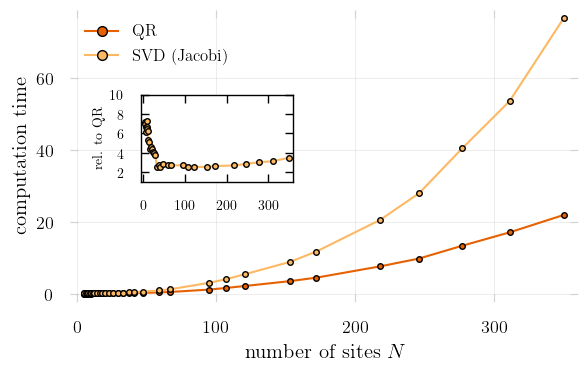

In [33]:
@load "benchmark_jacobi_vs_qr_tdgf.bson" df_vs_tdgf

@df df_vs_tdgf plot(:N, [:qr, :gesvj],
            marker=true,
            color=permutedims(["#E66101", "#FDB863"]),
            label=permutedims(["QR", "SVD (Jacobi)"]),
#             yscale=:log10
#             ylims=(0,50)
           )
xlabel!(L"number of sites $N$")
ylabel!("computation time")

# inset
@df df_vs_tdgf plot!(:N, [:gesvj ./ :qr],
            inset=(1, bbox(0.14,-0.06,0.3,0.3,:center,:left)),
            marker=true,
            color=permutedims(["#FDB863"]), # #E66101 for QR, "#008837", "#5E3C99", 
            label=permutedims([nothing]),
            subplot=2,
#             xlab=L"number of sites $N$",
            ylab="rel. to QR",
#             scale=:log10,
            grid=false,
            frame=:box,
            ylim=(1,10),
            guidefont=font(10),
            xtickfont=font(10), 
            ytickfont=font(10), 
            legendfont=font(9),
            yticks=[2,4,6,8,10],
           )
savefig("../paper/figures/benchmark_jacobi_vs_qr_tdgf.pdf")